<a href="https://colab.research.google.com/github/flying-bear/kompluxternaya/blob/master/Assignment_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 8
Develop a model for 20 news groups dataset from scikit-learn. Select 20% of data for test set.

Develop metric learning model with siamese network [3 points] and softmax loss or triplet loss [3 points] (from seminar). Use KNN and LSH (any library for approximate nearest neighbor search) for final prediction after the network was trained. [2 points]

! Remember, that LSH gives you a set of neighbor candidates, for which you have to calculate distances to choose top-k nearest neighbors.

Your quality metric = accuracy score [2 points if acc > 0.8 ]

In [50]:
!nvidia-smi

Mon Mar  9 17:49:34 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.59       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    33W / 250W |    759MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
import gensim
import gensim.downloader as api
import matplotlib.pyplot as plt
import numpy as np
import nltk
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, TensorDataset

from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from scipy.ndimage.filters import gaussian_filter1d
from tqdm import tqdm, tqdm_notebook

In [52]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [0]:
batch_size = 256
random_state = 42

In [0]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else tt.device('cpu')

In [0]:
newsgroups = fetch_20newsgroups()

In [0]:
df = pd.DataFrame(columns=['text', 'target'])
df['text'] = newsgroups.data
df['text']  = df['text'].apply(lambda sent: nltk.word_tokenize(sent))
df['target'] = newsgroups.target
df['target'] = df['target'].apply(float)

## Embeddings

In [57]:
wv = api.load('word2vec-google-news-300')
wv['king'][:10]

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


array([ 0.12597656,  0.02978516,  0.00860596,  0.13964844, -0.02563477,
       -0.03613281,  0.11181641, -0.19824219,  0.05126953,  0.36328125],
      dtype=float32)

In [0]:
emb_dim = wv['king'].size

In [0]:
def vectorize_sent(sent, wv):
  sent_vec = []
  for w in sent:
    try:
      vec = wv[w]
      sent_vec.append(vec)
    except KeyError:
      continue
  return np.mean(np.array(sent_vec), axis=0)

In [59]:
vectorize_sent(['I', 'am', 'so', 'tired'], wv)[:10]

array([ 0.01989746,  0.02895355,  0.0226059 ,  0.08935547, -0.05071735,
        0.06285095,  0.07019043, -0.09034729,  0.0916748 ,  0.08752441],
      dtype=float32)

In [0]:
df['vec'] = df['text'].apply(lambda sent: vectorize_sent(sent, wv))

In [61]:
df.head()

,text,target,vec
0,"[From, :, lerxst, @, wam.umd.edu, (, where, 's...",7.0,"[0.032288477, 0.03263666, 0.07366503, 0.066889..."
1,"[From, :, guykuo, @, carson.u.washington.edu, ...",4.0,"[-0.020951407, 0.072069034, 0.043153763, 0.052..."
2,"[From, :, twillis, @, ec.ecn.purdue.edu, (, Th...",4.0,"[0.02607478, 0.023831822, 0.02035976, 0.102583..."
3,"[From, :, jgreen, @, amber, (, Joe, Green, ), ...",1.0,"[-0.005437399, -0.0005287288, 0.017397419, 0.0..."
4,"[From, :, jcm, @, head-cfa.harvard.edu, (, Jon...",14.0,"[-0.07343274, 0.00018738056, 0.033099294, 0.09..."


### add negative and positive

In [0]:
def add_positive(row, df):
  target = row['target'] 
  vec = row['vec']
  positive = df[df['target'] == target]['vec']
  selected = np.random.choice(positive)
  while selected.tolist() == vec.tolist():
    selected = np.random.choice(positive)
  return selected

In [0]:
def add_negative(row, df):
  target = row['target'] 
  vec = row['vec']
  negative = df[df['target'] != target]['vec']
  return np.random.choice(negative)

In [64]:
positives = []
negatives = []
for i, row in df.iterrows():
  positives.append(add_positive(row, df))
  negatives.append(add_negative(row, df))
len(positives)

11314

In [0]:
df['positive'] = positives
df['negative'] = negatives

In [66]:
df.head()

,text,target,vec,positive,negative
0,"[From, :, lerxst, @, wam.umd.edu, (, where, 's...",7.0,"[0.032288477, 0.03263666, 0.07366503, 0.066889...","[-0.016801193, 0.043750726, 0.02573403, 0.0982...","[-0.023520788, -0.037075657, 0.04633649, 0.046..."
1,"[From, :, guykuo, @, carson.u.washington.edu, ...",4.0,"[-0.020951407, 0.072069034, 0.043153763, 0.052...","[0.019448416, 0.012540248, 0.03226182, 0.10422...","[-0.05689256, -1.608861e-05, 0.023813125, 0.09..."
2,"[From, :, twillis, @, ec.ecn.purdue.edu, (, Th...",4.0,"[0.02607478, 0.023831822, 0.02035976, 0.102583...","[0.0005824312, 0.012559735, 0.02057867, 0.0746...","[-0.019356176, 0.002154373, 0.07111602, 0.0900..."
3,"[From, :, jgreen, @, amber, (, Joe, Green, ), ...",1.0,"[-0.005437399, -0.0005287288, 0.017397419, 0.0...","[0.010827697, 0.014452622, 0.03526863, 0.06302...","[-0.027866324, 0.02060047, 0.061406907, 0.1130..."
4,"[From, :, jcm, @, head-cfa.harvard.edu, (, Jon...",14.0,"[-0.07343274, 0.00018738056, 0.033099294, 0.09...","[0.012298131, 0.018696018, 0.05699073, 0.10540...","[-0.015447801, 0.018567657, 0.042310752, 0.079..."


### form batches

In [0]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=random_state, shuffle=True)
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=random_state, shuffle=True)

In [0]:
class Batch:
  def __init__(self, anchors, positives, negatives, targets):
    self.anc = anchors
    self.pos = positives
    self.neg = negatives
    self.tgt = targets

In [0]:
class Iterator:
  def __init__(self, df, batch_size=128, device='cpu'):
    self.batches = self.make_batches(df, batch_size, device)

  @staticmethod
  def make_batches(df, batch_size, device):
    batches = []
    shuffled = df.sample(frac=1)
    i = 0
    while i < len(df):
      b = shuffled[i: i+batch_size]
      if len(b) == batch_size:
        anc = torch.tensor(list(b.vec.values)).to(device)
        pos = torch.tensor(list(b.positive.values)).to(device)
        neg = torch.tensor(list(b.negative.values)).to(device)
        tgt = torch.tensor(list(b.target.values)).to(device)
        batch = Batch(anc, pos, neg, tgt)
        batches.append(batch)
      i += batch_size
    return batches

In [70]:
Iterator(df, batch_size=batch_size, device=DEVICE).batches[0].pos

tensor([[-0.0677, -0.0115,  0.0479,  ..., -0.0248,  0.0321, -0.0339],
        [-0.0020,  0.0125,  0.0552,  ..., -0.0196,  0.0397, -0.0138],
        [-0.0180,  0.0081,  0.0297,  ..., -0.0602,  0.0237, -0.0415],
        ...,
        [-0.0393,  0.0270,  0.0303,  ..., -0.0027,  0.0395, -0.0127],
        [ 0.0606,  0.0232,  0.0271,  ..., -0.0236, -0.0061, -0.0570],
        [ 0.0296, -0.0002,  0.0269,  ..., -0.0504,  0.0171, -0.0089]],
       device='cuda:0')

In [0]:
trn_itr = Iterator(train_df, batch_size=batch_size, device=DEVICE).batches
vld_itr = Iterator(val_df, batch_size=batch_size, device=DEVICE).batches
tst_itr = Iterator(test_df, batch_size=batch_size, device=DEVICE).batches

In [0]:
len_train = len(trn_itr)
len_valid = len(vld_itr)
len_test = len(tst_itr)

## Network

In [0]:
class MyModel(nn.Module):
    
    def __init__(self, inp_dim=300, lin_dim=128):
        super(MyModel, self).__init__()
        self.fc = nn.Linear(inp_dim, lin_dim)
        
    def branch(self, x):
        x = self.fc(x)
        return x
        
    def forward(self, batch):
        anc = batch.anc
        pos = batch.pos
        neg = batch.neg
        
        anc = self.branch(anc)
        pos = self.branch(pos)
        neg = self.branch(neg)
        
        return anc, pos, neg


In [0]:
def train_epoch(data_iter, len_iter, n_epoch, model, criterion, optimizer=None):
    train_losses = []
    total_loss = 0
    data_iter = tqdm_notebook(data_iter, total=len_iter, desc=f"Epoch {n_epoch + 1}", leave=True)
    counter = 0
    for batch in data_iter:
        if optimizer:
          optimizer.zero_grad()
        anc, pos, neg = model.forward(batch)
        loss = criterion(anc, pos, neg)
        loss.backward()
        if optimizer:
          optimizer.step()
        loss_value = loss.detach().item()
        total_loss += loss_value
        train_losses.append(loss_value)
        data_iter.set_postfix(loss = loss_value)
        counter += 1
        
    total_loss /= counter
    return total_loss, train_losses


def valid_epoch(data_iter, len_iter, n_epoch, model, criterion):
    valid_losses = []
    total_loss = 0
    data_iter = tqdm_notebook(data_iter, total=len_iter, desc=f"Eval epoch {n_epoch + 1}", leave=True)
    counter = 0
    for batch in data_iter:
        with torch.no_grad():
            anc, pos, neg = model.forward(batch)
            loss = criterion(anc, pos, neg)
            loss_value = loss.detach().item()
            total_loss += loss_value
            valid_losses.append(loss_value)
            data_iter.set_postfix(loss = loss_value)
            counter +=1
        
    total_loss /= counter
    return total_loss, valid_losses

### Loss

In [0]:
class TripletLoss(nn.L1Loss):
  def __init__(self, margin=0.1):
    super(TripletLoss, self).__init__()
    self.margin = margin
  
  def forward(self, anc, pos, neg):
    return torch.mean(F.cosine_similarity(anc, neg, dim=-1) - F.cosine_similarity(anc, pos, dim=-1) + self.margin)

In [76]:
criterion = TripletLoss()
criterion(torch.tensor([[1.0,2.0,3.0], [1.0,1.0,2.0]]), torch.tensor([[1.0,1.0,1.0], [1.0,0.0,2.0]]), torch.tensor([[0.0,0.0,0.0], [0.0,2.0,10.0]]))

tensor(-0.3790)

## Train

In [0]:
criterion = TripletLoss()
criterion = criterion.to(DEVICE)
model = MyModel(inp_dim=emb_dim, lin_dim=512)
model = model.to(DEVICE)
optimizer = torch.optim.Adam(model.parameters())
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)

In [0]:
num_epochs = 15

In [123]:
total_train_losses = []
total_valid_losses = []
for epoch in range(num_epochs):
    model.train()
    loss, train_losses = train_epoch(trn_itr, len_train, epoch, model, criterion, optimizer)
    total_train_losses += train_losses
    print('train', loss)
    
    model.eval()
    with torch.no_grad():
        loss, valid_losses = valid_epoch(vld_itr, len_valid, epoch, model, criterion)
        total_valid_losses += valid_losses
        if scheduler:
          if type(scheduler) == torch.optim.lr_scheduler.ReduceLROnPlateau:
            scheduler.step(loss)
          else:
            scheduler.step() 
        print('valid', loss)


train -0.25997267507257



valid -0.46416090925534564



train -0.5361356754456797



valid -0.5526860952377319



train -0.6025515544799066



valid -0.5841647585233053



train -0.637180414892012



valid -0.6025231877962748



train -0.6608054022635182



valid -0.6152382294336954



train -0.6787427375393529



valid -0.6251387000083923



train -0.6931519931362521



valid -0.6335259278615316



train -0.7052004952584544



valid -0.6409406463305155



train -0.7154769436005624



valid -0.6474945743878683



train -0.724289471103299



valid -0.6531778971354166



train -0.73187481780206



valid -0.6580074628194174



train -0.738449260111778



valid -0.6620633602142334



train -0.7442087954090487



valid -0.6654746929804484



train -0.7493244371106548



valid -0.6683491468429565



train -0.7539254503865396



valid -0.6707558830579122


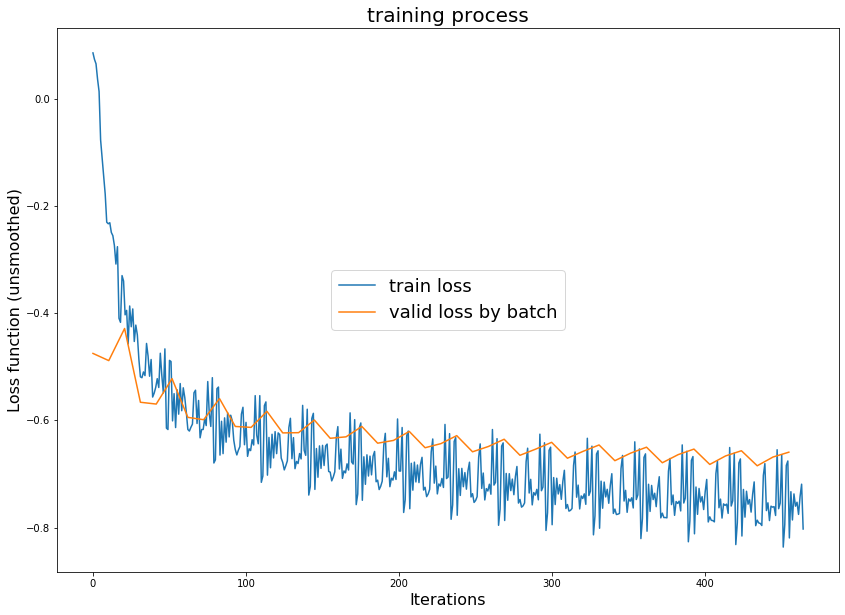

In [124]:
plt.figure(figsize=(14, 10))
plt.plot(range(len(total_train_losses)), total_train_losses, np.array(range(len(total_valid_losses)))*(len(total_train_losses)/len(total_valid_losses)), total_valid_losses)
plt.legend(('train loss', 'valid loss by batch'),
           loc='center', prop={'size': 18})
plt.title('training process', fontsize=20)
plt.xlabel('Iterations', fontsize=16)
plt.ylabel('Loss function (unsmoothed)', fontsize=16)
plt.show()

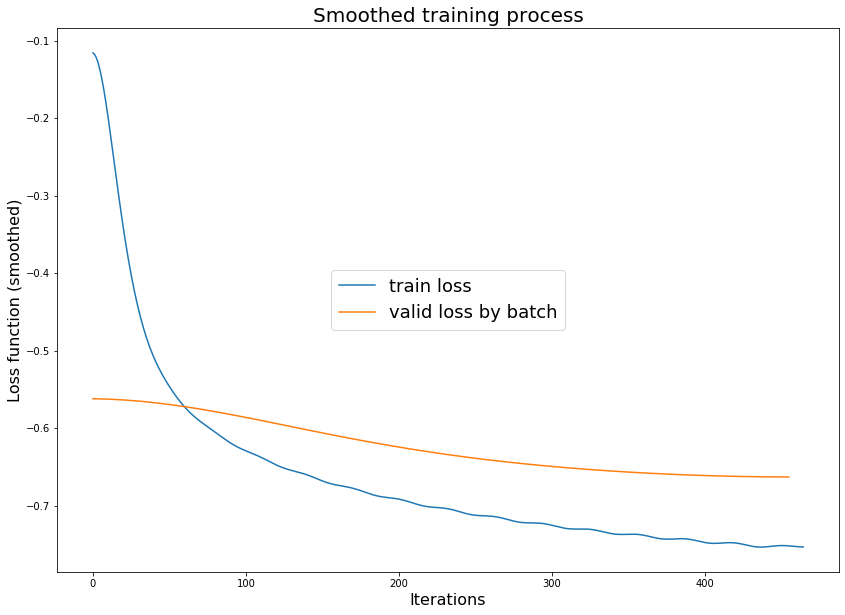

In [125]:
smooth = lambda y: gaussian_filter1d(y, sigma=10)

plt.figure(figsize=(14, 10))
plt.plot(range(len(total_train_losses)), smooth(total_train_losses), np.array(range(len(total_valid_losses)))*(len(total_train_losses)/len(total_valid_losses)), smooth(total_valid_losses))
plt.legend(('train loss', 'valid loss by batch'),
           loc='center', prop={'size': 18})
plt.title('Smoothed training process', fontsize=20)
plt.xlabel('Iterations', fontsize=16)
plt.ylabel('Loss function (smoothed)', fontsize=16)
plt.show()

## Predict


In [148]:
predict_vecs = []
predict_tgts = []
model.eval()
with torch.no_grad():
  data_iter = tqdm_notebook(tst_itr, total=len_test, desc=f"Test", leave=True)
  for batch in data_iter:
    anc, pos, neg = model.forward(batch)
    tgt = batch.tgt
    predict_vecs.append(anc.cpu().detach().numpy())
    predict_tgts += tgt.cpu().detach()

In [176]:
predict_df = pd.DataFrame(columns=['target', 'vec'])
predict_df['target'] = [x.item() for x in predict_tgts]
predict_df['vec'] = list(np.concatenate(predict_vecs))
predict_df.tail()

,target,vec
2043,10.0,"[0.025157703, 0.036540046, -0.04017117, -0.050..."
2044,2.0,"[-0.07610571, -0.042743195, -0.035869353, 0.06..."
2045,15.0,"[0.056401584, 0.023858132, 0.039060943, -0.049..."
2046,13.0,"[0.0006971962, -0.00037616864, 0.01601189, 0.0..."
2047,7.0,"[-0.02683389, -0.013489235, -0.044622414, 0.02..."


## Nearest neighbours

In [195]:
X = np.array([[-1, -1, 3], [-2, -1, 12], [-3, -2, 1], [1, 1, 1], [1, 2, 1], [1, 3, 2]])
nbrs = NearestNeighbors(n_neighbors=3, algorithm='ball_tree').fit(X)
x_distances, x_indices = nbrs.kneighbors(X)
x_indices

array([[0, 2, 3],
       [1, 0, 2],
       [2, 0, 3],
       [3, 4, 5],
       [4, 3, 5],
       [5, 4, 3]])

In [196]:
x_distances

array([[ 0.        ,  3.        ,  3.46410162],
       [ 0.        ,  9.05538514, 11.09053651],
       [ 0.        ,  3.        ,  5.        ],
       [ 0.        ,  1.        ,  2.23606798],
       [ 0.        ,  1.        ,  1.41421356],
       [ 0.        ,  1.41421356,  2.23606798]])

In [0]:
predicted = np.concatenate(predict_vecs)
nbrs = NearestNeighbors(n_neighbors=3, algorithm='ball_tree').fit(predicted)
distances, indices = nbrs.kneighbors(predicted)

In [0]:
predicted_classes = []
for i, row in predict_df.iterrows():
  distances_to_classes = [100]*20
  distances_i = distances[i]
  indices_i = indices[i]
  for n_i, n_d in enumerate(distances_i):
    class_n = predict_df['target'][indices_i[n_i]]
    if distances_to_classes[int(class_n)] == 100:
      distances_to_classes[int(class_n)] = n_d
    else:
      distances_to_classes[int(class_n)] += n_d
  class_i = distances_to_classes.index(min(distances_to_classes))

  predicted_classes.append(class_i)

In [229]:
accuracy_score(y_true = list(predict_df.target.values), y_pred=predicted_classes)

0.8583984375